In [12]:
%pip install annoy

Note: you may need to restart the kernel to use updated packages.


Exact NN index: [64040 64186 88792]
Exact NN jarak: [0.         0.15797867 0.25332711]
Waktu Exact: 4.9999 ms

Annoy NN index: [59477, 12303, 1267]
Annoy NN jarak: [np.float64(88.80155239749594), np.float64(63.528489005301076), np.float64(20.944979198306577)]
Waktu Annoy: 0.0 ms


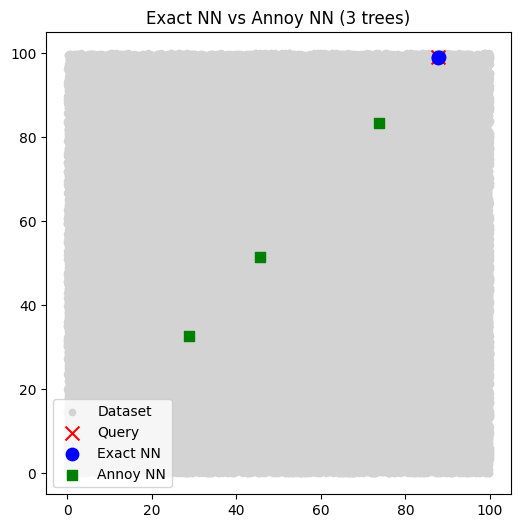

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import time

from annoy import AnnoyIndex

# 1. Dataset 2D
np.random.seed(42)
n_points = 100000
X = np.random.rand(n_points, 2) * 100  # titik random dalam ruang 100x100

# Query point (ambil salah satu titik random)
query = X[np.random.randint(0, n_points)]

# 2. Exact NN (brute force)
start = time.time()
distances = np.linalg.norm(X - query, axis=1)
idx_exact = np.argsort(distances)[:3]  # ambil 3 terdekat
time_exact = time.time() - start

print("Exact NN index:", idx_exact)
print("Exact NN jarak:", distances[idx_exact])
print("Waktu Exact:", round(time_exact*1000, 4), "ms")

# 3. Annoy NN (3 tree)
f = 2  # dimensi
t = AnnoyIndex(f, 'angular')  
for i, vec in enumerate(X):
    t.add_item(i, vec)

t.build(3)  # 3 trees

start = time.time()
idx_ann = t.get_nns_by_vector(query, 3)  # cari 3 NN
time_ann = time.time() - start

print("\nAnnoy NN index:", idx_ann)
print("Annoy NN jarak:", [np.linalg.norm(X[i]-query) for i in idx_ann])
print("Waktu Annoy:", round(time_ann*1000, 4), "ms")

# 4. Visualisasi hasil
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c="lightgray", s=20, label="Dataset")
plt.scatter(query[0], query[1], c="red", marker="x", s=100, label="Query")

# Exact NN ditandai biru
plt.scatter(X[idx_exact,0], X[idx_exact,1], c="blue", s=80, label="Exact NN")

# Annoy NN ditandai hijau
plt.scatter(X[idx_ann,0], X[idx_ann,1], c="green", s=50, marker="s", label="Annoy NN")

plt.legend()
plt.title("Exact NN vs Annoy NN (3 trees)")
plt.show()

Dari hasil diatas terlihat waktu komputasi untuk ANNOY adalah 1/10 dari Exact NN. Lakukan percobaan dan isikan hasil percobaan pada tabel berikut.

| Distance Metrics | Tree | Jumlah data | Hasil Index terdekat ENN vs ANN | Waktu komputasi Vs |
|-----------------|------|------------|--------------------------------|-------------------|
| Euclidean       | 3    | 1000       | [219, 898, 593], [219, 898, 593] | 1.2271 ms vs 0.1264 ms |
| Euclidean       | 8    | 1000       | [219, 898, 593], [219, 898, 593] | 1.0016 ms vs 1.0016 ms |
| Euclidean       | 3    | 100,000    | [64040 64186 88792], [64040, 64186, 88792] | 6.9983 ms vs 0.0 ms |
| Angular         | 3    | 1000       | [219 898 593], [219, 429, 540] | 1.0018 ms vs 0.0 ms |
| Angular         | 8    | 1000       | [219 898 593], [219, 429, 540] | 0.0 ms vs 0.0 ms |
| Angular         | 3    | 100,000    | [64040 64186 88792], [59477, 12303, 1267] | 4.9999 ms vs 0.0 ms |

Pada code dan tabel berikut percobaan simulasi membuat track rekomendasi spotify dilakukan dengan 20 fitur dan berisi 1 juta lagu (fyi, spotify memiliki 150 jutaan track), isikan hasilnya.

In [30]:
import numpy as np
import time
from sklearn.metrics.pairwise import euclidean_distances # untuk metrik Euclidean
from sklearn.metrics.pairwise import cosine_distances # untuk metrik angular
from annoy import AnnoyIndex

# ---- 1. Buat dataset mirip Spotify ----
n_tracks = 1_000_000   # 50 juta track
n_features = 20        # contoh: danceability, energy, tempo, dll.

# dataset besar (random untuk simulasi)
X = np.random.rand(n_tracks, n_features).astype(np.float32)

# query track (misalnya lagu baru)
query = np.random.rand(1, n_features).astype(np.float32)

# ---- 2. Exact NN (brute force) ----
start = time.time()
distances = cosine_distances(query, X)[0]   # hitung semua jarak
exact_idx = np.argsort(distances)[:5]          # ambil 5 terdekat
exact_time = time.time() - start

print("Exact NN result:", exact_idx)
print("Exact NN time:", round(exact_time, 3), "seconds")

# ---- 3. Approx NN pakai Annoy ----
f = n_features
annoy_index = AnnoyIndex(f, 'angular')  # 
n_trees = 8

# build index
# start = time.time()
for i in range(n_tracks):
    annoy_index.add_item(i, X[i])
annoy_index.build(n_trees)
# build_time = time.time() - start
# print("Build time:", round(build_time, 3), "seconds")

start = time.time()
annoy_idx = annoy_index.get_nns_by_vector(query[0], 5)  # ambil 5 lagu yang mirip
annoy_time = time.time() - start

print("Annoy result:", annoy_idx)
print("Annoy time:", round(annoy_time, 3), "seconds")


Exact NN result: [277938 595766 376500 212639 350752]
Exact NN time: 0.097 seconds
Build time: 3.372 seconds
Annoy result: [137102, 393367, 665230, 484132, 24529]
Annoy time: 0.0 seconds


| Distance Metrics | Tree | Jumlah data | Hasil Index terdekat ENN vs ANN | Waktu komputasi Vs |
|-----------------|------|------------|--------------------------------|-------------------|
| Euclidean       | 8    | 1000000    | [718951 566929 443116 573985 715960] vs [715960, 883955, 170362, 912843, 907861] | 0.06 s vs 0.001 s |
| Angular         | 8    | 1000000    | [509918 125899 881660 842356 448888] vs [881660, 845642, 151383, 154456, 132070] | 0.109 s vs 0.0 s |


Pertanyaannya: Kenapa code dibagian build index tidak dihitung waktunya? 

>karena pada kasus spotify, build hanya dijalankan sekali saat pengembangan sedangkan pencarian akan dilakukan berkali kali. jadi yang dibandingkan hanya waktu kecepatan pencariannya